<img src="./Imagenes/3.1.png" >    

In [1]:
import pmdarima as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime 
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from arch.univariate import arch_model

In [2]:
data = pd.read_csv("Tasa_de_Cambio_Representativa_del_Mercado-_TRM.csv",sep= ',', decimal=",")
data.head()

,VALOR,UNIDAD,VIGENCIADESDE,VIGENCIAHASTA
0,"2,850.98",COP,09/10/2002,09/10/2002
1,"2,854.04",COP,10/10/2002,10/10/2002
2,"2,870.63",COP,11/10/2002,11/10/2002
3,"2,861.16",COP,12/10/2002,15/10/2002
4,"2,852.99",COP,16/10/2002,16/10/2002


In [3]:
data.tail()

,VALOR,UNIDAD,VIGENCIADESDE,VIGENCIAHASTA
6963,"3,763.82",COP,06/11/2020,06/11/2020
6964,"3,738.19",COP,07/11/2020,09/11/2020
6965,"3,646.15",COP,10/11/2020,10/11/2020
6966,"3,650.50",COP,11/11/2020,12/11/2020
6967,"3,646.22",COP,13/11/2020,13/11/2020


### Organizando la data:

In [4]:
# se deja la fecha vigenciadesde desde para que los viernes tengan esa TRM del viernes.

data.index = pd.to_datetime(data.VIGENCIADESDE) # volviendo el dato de fecha y dejandolo como el indice de la data
data.drop(['VIGENCIADESDE','VIGENCIAHASTA','UNIDAD'], axis = 'columns', inplace=True) #eliminando las variables no relevantes
data = data.sort_values(by=["VIGENCIADESDE"]) # ordenando las fechas
data.head() # datas diarios

,VALOR
VIGENCIADESDE,
1991-02-12,643.42
1991-03-12,639.22
1991-04-12,635.70
1991-05-12,631.51
1991-06-12,627.16


In [5]:
data = pd.DataFrame(data[data.index.is_month_end]) # filtrando la ultima fecha del mes 
data # tenemos datos mensuales.

,VALOR
VIGENCIADESDE,
1991-12-31,632.37
1992-01-31,644.27
1992-02-29,636.54
1992-03-31,641.59
1992-04-30,653.83
...,...
2020-03-31,"4,064.81"
2020-04-30,"3,983.29"
2020-07-31,"3,739.49"


* En python los numeros flotantes (TRM) no se lee como 3,858.25 sino como 3858.25. Luego hacemos tratamiento sobre los datos para construir el modelo posteriormente y analizamos como se comporta la TRM a lo largo del tiempo:

In [6]:
data['VALOR'] = data['VALOR'].str.replace(",", "").astype(float)

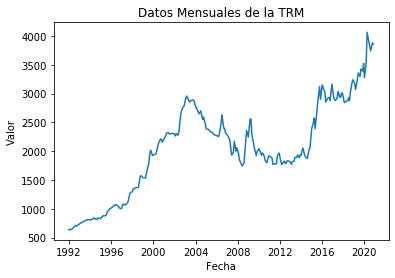

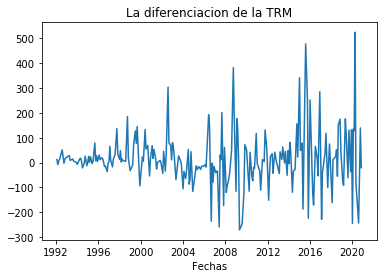

In [7]:
plt.plot(data['VALOR'])
plt.title('Datos Mensuales de la TRM')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.show()

plt.plot(data.diff().dropna()) 
plt.title('La diferenciacion de la TRM')
plt.xlabel('Fechas')
plt.show()

* Note que con la diferenciación removemos tendencia ó volvemos constante el primer momento. Aunque la serie parece ser heterocedastica ó irregular en la varianza a lo largo del tiempo.

<img src="./Imagenes/3.15 .png" >    

* Separando la base de entrenamiento (antes del 2018 ) y la base de prueba (despues de 2018)

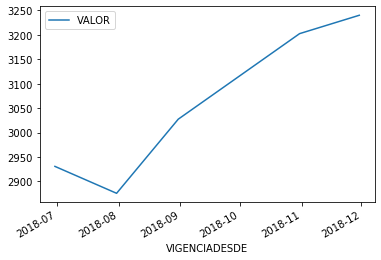

In [8]:
train = data[data.index.year <=  2018 ]  
train.tail().plot()

### Test de estacionariedad en la TRM:

In [9]:
result = adfuller(data)
print("The p-value for the ADF test is ", result[1])  # raiz unitaria !!

The p-value for the ADF test is  0.8588399493451474


### Estructurando los modelos ARMA con la diferenciación en los precisos con la base de entrenamiento ó con los datos hasta el 2018:

The p-value for the ADF test is  2.4229534681333586e-26


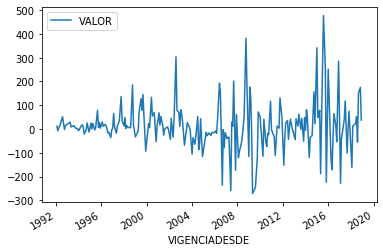

In [10]:
train = train.diff().dropna()

result = adfuller(train)
print("The p-value for the ADF test is ", result[1]) # proceso estacionario
train.plot()

### Analizamos los autocorrelogramas (Simple, Parcial)

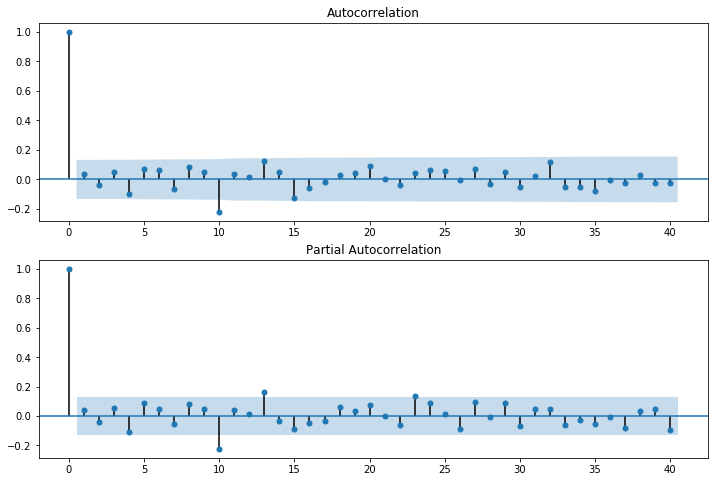

In [11]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train, lags=40, ax=ax2)

### Modelo 1:
Considerando que no existe correlación significativa ó fuerte en los autocorrelogramas ACF y PACF para especular un modelo ARMA(P,Q) y no se pregunta por modelos SARIMAX. 

Vamos a realizar una grilla y seleccionar el mejor modelo de un autoarima con la mejor informacion AIC:

In [12]:
information_criterion='aic'

In [13]:
# yoo (falta el test de dicky fuller):

modelo1 = pm.auto_arima(train, 
                      # la serie es ciclica:
                      seasonal=False, m=0, # no tiene ciclo la serie 
                      # sabemos por dicky fuller que:
                      d=0, D=0, # No diferencio el arima (d=9)  y diferencio el Sarima (D=1)!
                      # loop del arima(p,0,q):
                      start_p = 0, start_q=0,
                      max_p=12, max_q=12,
                      trace=True, # imprima el loop
                      information_criterion = information_criterion, # le creo mas al bic que al aic
                      error_action='ignore', # si no se pudo correr un modelo siga
                      stepwise = True, # haga el loop inteligentemente
                      suppress_warnings=True) 

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2633.208, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2634.582, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2634.539, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2631.642, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2633.638, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2633.639, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2636.224, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2636.405, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2634.616, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2630.573, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2633.597, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2633.631, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2632.552, Time=0.40 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2632.553, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept

In [14]:
print(modelo1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  219
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1311.287
Date:                Thu, 19 Nov 2020   AIC                           2630.573
Time:                        16:02:30   BIC                           2644.130
Sample:                             0   HQIC                          2636.048
                                - 219                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     22.4616     13.535      1.660      0.097      -4.066      48.989
ar.L1         -0.8884      0.072    -12.418      0.000      -1.029      -0.748
ma.L1          0.9615      0.050     19.399      0.0

#### El mejor modelo es un ARMA(1,1) ó SARIMAX(1,0,1)(0,0,0) bajo el criterio de AIC. Agregando que segun el test de Ljung-Box no podemos rechazar la Hipotesis Nula y existe independencia en los errores. Pero el test de Heterocedasticidad y Jarque Bera rechaza la Hipotesis nula y por ende el modelo es heterocedastico y el error no es una distribucion normal estandar.

#### El modelo no es explosivo.

### ANALISIS GRAFICO SOBRE LOS RESIDUALES

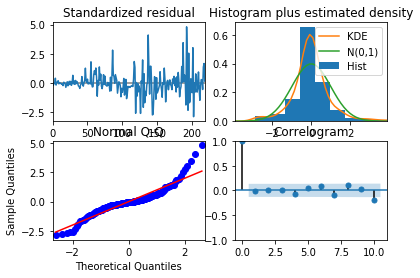

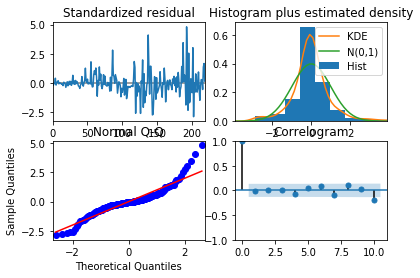

In [15]:
modelo1.plot_diagnostics()

### Modelo 2:

Se realizara una grilla ó tunning sobre el orden p,q para determinar el mejor modelo arma bajo el criterio de información de BIC.


In [16]:
information_criterion='bic'

In [17]:
modelo2 = pm.auto_arima(train,
                      trace=True, # imprima el loop
                      information_criterion = information_criterion # le creo mas al bic que al aic
                       )

Performing stepwise search to minimize bic


C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:437: ModelFitWarning: Error fitting  ARIMA(2,0,2)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 421, in _fit_candidate_model
    fit.fit(x, exogenous=xreg, **fit_params)
  File "C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 472, in fit
    self._fit(y, exogenous, **fit_args)
  File "C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 397, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 389, in _fit_wrapper
    **fit_args)
  File "C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\statsmodels\tsa\statespace

 ARIMA(2,0,2)(0,0,0)[0] intercept   : BIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=2638.752, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=2643.798, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=2643.764, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=2636.597, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=2644.130, Time=0.19 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 2.377 seconds


#### Note que el mejor modelo segun BIC es un ARMA(0,0) que fue el que se observaba en los autocorrelogramas. Para evitar esto voy a seleccionar el 2 mejor modelo bajo este criterio (Modelo que esta en segundo lugar con BIC mas pequeño). Este modelo es un ARMA(0,1) ó un MA(1):

In [18]:
modelo2 = SARIMAX(train, order = (0,0,1)).fit()
print(modelo2.summary())

                               SARIMAX Results                                
Dep. Variable:                  VALOR   No. Observations:                  219
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -1315.269
Date:                Thu, 19 Nov 2020   AIC                           2634.539
Time:                        16:02:55   BIC                           2641.317
Sample:                             0   HQIC                          2637.276
                                - 219                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0572      0.043      1.320      0.187      -0.028       0.142
sigma2      9640.2831    525.328     18.351      0.000    8610.659    1.07e+04
Ljung-Box (Q):                       45.30   Jarque-

C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


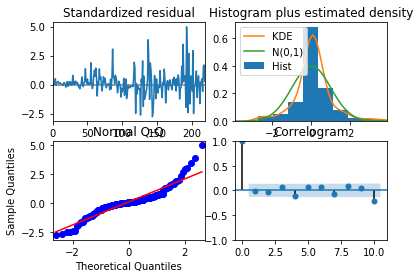

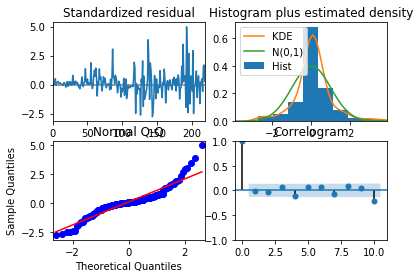

In [19]:
modelo2.plot_diagnostics()

### Modelo3:
* AR(2)

In [21]:
modelo3 = SARIMAX(train, order = (2,0,0)).fit()
print(modelo3.summary())

                               SARIMAX Results                                
Dep. Variable:                  VALOR   No. Observations:                  219
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1315.202
Date:                Thu, 19 Nov 2020   AIC                           2636.405
Time:                        16:03:06   BIC                           2646.572
Sample:                             0   HQIC                          2640.511
                                - 219                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0549      0.044      1.243      0.214      -0.032       0.141
ar.L2         -0.0284      0.049     -0.574      0.566      -0.125       0.069
sigma2      9634.1823    525.183     18.344      0.0

C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


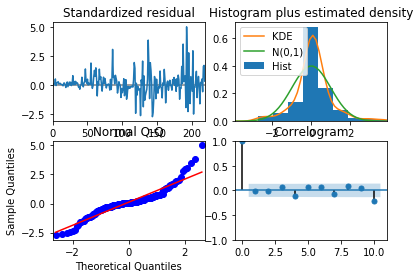

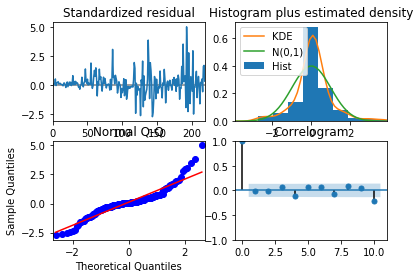

In [22]:
modelo3.plot_diagnostics()

<img src="./Imagenes/3.3 .png" >    

In [23]:
def RMSE(real, forecast):
    metrica = 0
    for i in range(len(real)):
        metrica = metrica + (real[i] - forecast[i])**2 
    metrica = metrica/len(real)
    metrica = np.sqrt(metrica)
    
    return(round(metrica,5))

def MAE(real, forecast):
    metrica = 0
    for i in range(len(real)):
        metrica = metrica + np.abs(real[i] - forecast[i])
    metrica = metrica/len(real)   
    return(round(metrica,5))

In [24]:
sept_2019 = datetime(2019,10,1)  # un dia despues al ultimo dia del mes de septiembre (para incluir septiembre).

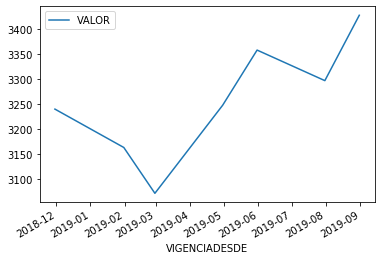

In [25]:
test = data[data.index < sept_2019]
test.tail(7).plot()

Creando la función para hacer la rolling window:

In [26]:
def rolling_window(p,q, data,n_ahead,step):
    predict = []
    lower_limits = []
    upper_limits = []
    for i in range(n_ahead):
        rolling_data = data.iloc[i:data.shape[0] + i - n_ahead] # data para entrenar el modelo
        modelito = SARIMAX(rolling_data, order = (p,1,q)).fit() # fiteando
        dia_adelante = modelito.get_forecast(steps=step) # pronosticando de mes a mes 
        predict.append(float(dia_adelante.predicted_mean) ) # guardando el pronostico medio
        
        # intervalo de confianza 
        confidence_intervals = dia_adelante.conf_int()
        # guardando el intervalo de confianza bajo y max
        lower_limits.append(float(confidence_intervals.loc[:,'lower VALOR']))
        upper_limits.append(float(confidence_intervals.loc[:,'upper VALOR']))
    return(predict,lower_limits , upper_limits)


### Realizando la rolling window para:
* El modelo 1 : ARMA(1,1)
* El modelo 2 : MA(1)
* El modelo 3 : AR(2)

In [29]:
# arma(1,1):
arma_predict, arma_lw_limits, arma_up_limits = rolling_window(p = 1,q = 1, data = test,n_ahead = 9 ,step = 1)

# ma(1):
ma_predict, ma_lw_limits, ma_up_limits = rolling_window(p = 0,q = 1, data = test,n_ahead = 9 ,step = 1)

# ar(2):
ar_predict, ar_lw_limits, ar_up_limits = rolling_window(p = 2,q = 0, data = test,n_ahead = 9 ,step = 1)

C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters 

C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency inf

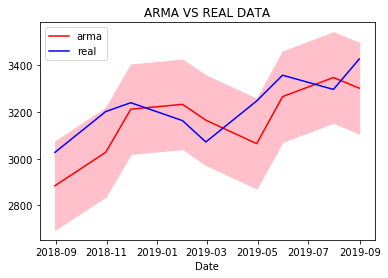

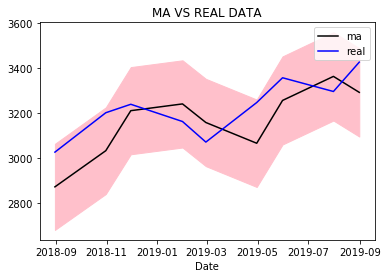

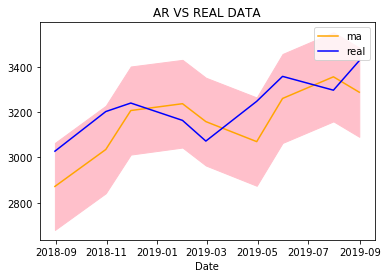

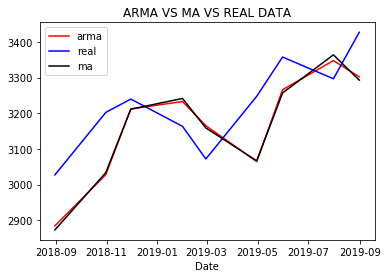

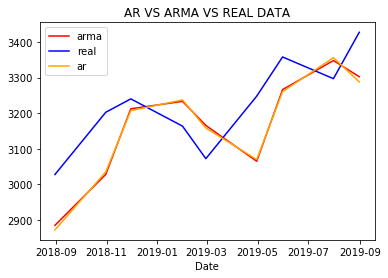

In [30]:
plt.plot(test.tail(9).index,arma_predict, label = 'arma', c='r')
plt.plot(test.tail(9), label = 'real', c= 'b')
plt.fill_between(test.tail(9).index,arma_lw_limits, arma_up_limits, color='pink')
plt.xlabel('Date')
plt.title('ARMA VS REAL DATA')
plt.legend()
plt.show()

plt.plot(test.tail(9).index,ma_predict, label = 'ma', c='black')
plt.plot(test.tail(9), label = 'real', c= 'b')
plt.fill_between(test.tail(9).index,ma_lw_limits, ma_up_limits, color='pink')
plt.xlabel('Date')
plt.title('MA VS REAL DATA')
plt.legend()
plt.show()

plt.plot(test.tail(9).index,ar_predict, label = 'ma', c='orange')
plt.plot(test.tail(9), label = 'real', c= 'b')
plt.fill_between(test.tail(9).index,ar_lw_limits, ar_up_limits, color='pink')
plt.xlabel('Date')
plt.title('AR VS REAL DATA')
plt.legend()
plt.show()

plt.plot(test.tail(9).index,arma_predict, label = 'arma', c='r')
plt.plot(test.tail(9), label = 'real', c= 'b')
plt.plot(test.tail(9).index,ma_predict, label = 'ma', c='black')
plt.xlabel('Date')
plt.title('ARMA VS MA VS REAL DATA')
plt.legend()
plt.show()

plt.plot(test.tail(9).index,arma_predict, label = 'arma', c='r')
plt.plot(test.tail(9), label = 'real', c= 'b')
plt.plot(test.tail(9).index,ar_predict, label = 'ar', c='orange')
plt.xlabel('Date')
plt.title('AR VS ARMA VS REAL DATA')
plt.legend()
plt.show()

### Test de Diabold - Mariano:

In [31]:
def dm_test(actual_lst, pred1_lst, pred2_lst, h = 1, crit="MSE", power = 2):
    # Routine for checking errors
    def error_check():
        rt = 0
        msg = ""
        # Check if h is an integer
        if (not isinstance(h, int)):
            rt = -1
            msg = "The type of the number of steps ahead (h) is not an integer."
            return (rt,msg)
        # Check the range of h
        if (h < 1):
            rt = -1
            msg = "The number of steps ahead (h) is not large enough."
            return (rt,msg)
        len_act = len(actual_lst)
        len_p1  = len(pred1_lst)
        len_p2  = len(pred2_lst)
        # Check if lengths of actual values and predicted values are equal
        if (len_act != len_p1 or len_p1 != len_p2 or len_act != len_p2):
            rt = -1
            msg = "Lengths of actual_lst, pred1_lst and pred2_lst do not match."
            return (rt,msg)
        # Check range of h
        if (h >= len_act):
            rt = -1
            msg = "The number of steps ahead is too large."
            return (rt,msg)
        # Check if criterion supported
        if (crit != "MSE" and crit != "MAPE" and crit != "MAD" and crit != "poly"):
            rt = -1
            msg = "The criterion is not supported."
            return (rt,msg)  
        # Check if every value of the input lists are numerical values
        from re import compile as re_compile
        comp = re_compile("^\d+?\.\d+?$")  
        def compiled_regex(s):
            """ Returns True is string is a number. """
            if comp.match(s) is None:
                return s.isdigit()
            return True
        for actual, pred1, pred2 in zip(actual_lst, pred1_lst, pred2_lst):
            is_actual_ok = compiled_regex(str(abs(actual)))
            is_pred1_ok = compiled_regex(str(abs(pred1)))
            is_pred2_ok = compiled_regex(str(abs(pred2)))
            if (not (is_actual_ok and is_pred1_ok and is_pred2_ok)):  
                msg = "An element in the actual_lst, pred1_lst or pred2_lst is not numeric."
                rt = -1
                return (rt,msg)
        return (rt,msg)
    
    # Error check
    error_code = error_check()
    # Raise error if cannot pass error check
    if (error_code[0] == -1):
        raise SyntaxError(error_code[1])
        return
    # Import libraries
    from scipy.stats import t
    import collections
    import pandas as pd
    import numpy as np
    
    # Initialise lists
    e1_lst = []
    e2_lst = []
    d_lst  = []
    
    # convert every value of the lists into real values
    actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
    pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
    pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()
    
    # Length of lists (as real numbers)
    T = float(len(actual_lst))
    
    # construct d according to crit
    if (crit == "MSE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((actual - p1)**2)
            e2_lst.append((actual - p2)**2)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAD"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs(actual - p1))
            e2_lst.append(abs(actual - p2))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAPE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs((actual - p1)/actual))
            e2_lst.append(abs((actual - p2)/actual))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "poly"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(((actual - p1))**(power))
            e2_lst.append(((actual - p2))**(power))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)    
    
    # Mean of d        
    mean_d = pd.Series(d_lst).mean()
    
    # Find autocovariance and construct DM test statistics
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
              autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d_lst,len(d_lst),lag,mean_d)) # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    DM_stat=V_d**(-0.5)*mean_d
    harvey_adj=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DM_stat = harvey_adj*DM_stat
    # Find p-value
    p_value = 2*t.cdf(-abs(DM_stat), df = T - 1)
    
    # Construct named tuple for return
    dm_return = collections.namedtuple('dm_return', 'DM p_value')
    
    rt = dm_return(DM = DM_stat, p_value = p_value)
    
    return rt

In [32]:
print('EL RMSE DEL ARMA: ',RMSE(test.tail(9)['VALOR'].tolist(),arma_predict))
print('EL RMSE DEL MA : ',RMSE(test.tail(9)['VALOR'].tolist(),ma_predict))
print('EL RMSE DEL AR : ',RMSE(test.tail(9)['VALOR'].tolist(),ar_predict))

EL RMSE DEL ARMA:  118.01692
EL RMSE DEL MA :  121.18605
EL RMSE DEL AR :  120.37145


In [33]:
print('EL MAE DEL ARMA: ',MAE(test.tail(9)['VALOR'].tolist(),arma_predict))
print('EL MAE DEL MA : ',MAE(test.tail(9)['VALOR'].tolist(),ma_predict))
print('EL MAE DEL AR : ',MAE(test.tail(9)['VALOR'].tolist(),ar_predict))

EL MAE DEL ARMA:  106.54576
EL MAE DEL MA :  111.07197
EL MAE DEL AR :  110.01419


##### Test entre modelo ARMA y MA:

In [34]:
dm_test(test.tail(9)['VALOR'].tolist(), arma_predict, ma_predict, h = 1, crit="MSE", power = 2) 
# p- value > 5% entonces no rechazo la hipotesis nula y soy indiferente a cualquier pronostico.

dm_return(DM=-1.2509732778777811, p_value=0.24628880065786898)

###### Test entre modelo AR y ARMA:

In [35]:
dm_test(test.tail(9)['VALOR'].tolist(), arma_predict, ar_predict, h = 1, crit="MSE", power = 2) 
# p- value > 5% entonces NO rechazo la hipotesis nula y el modelo AR(2) pronostica de forma similar el modelo ARMA(1,1)

dm_return(DM=-0.7591555415582579, p_value=0.46953460542158987)

<img src="./Imagenes/4.0 .PNG" >  

In [36]:
data = pd.read_csv("OxfordManRealizedVolatilityIndices.csv",sep=",",parse_dates=[0],index_col=[0])
data

,Symbol,rk_twoscale,bv_ss,bv,open_price,rv5,rk_parzen,close_time,rk_th2,rv10,nobs,rv5_ss,open_time,open_to_close,rsv,rv10_ss,rsv_ss,medrv,close_price
2000-01-03 00:00:00+00:00,.AEX,0.000103,0.000100,0.000100,675.67,0.000130,0.000179,163015.0,0.000102,0.000178,1795.0,0.000130,90101.0,-0.000340,0.000046,0.000178,0.000046,0.000050,675.44
2000-01-04 00:00:00+00:00,.AEX,0.000199,0.000207,0.000207,664.20,0.000201,0.000423,163016.0,0.000201,0.000261,1785.0,0.000201,90416.0,-0.033606,0.000147,0.000261,0.000147,0.000075,642.25
2000-01-05 00:00:00+00:00,.AEX,0.000325,0.000361,0.000361,633.37,0.000491,0.000324,163016.0,0.000345,0.000714,1801.0,0.000491,90016.0,-0.001675,0.000328,0.000714,0.000328,0.000166,632.31
2000-01-06 00:00:00+00:00,.AEX,0.000218,0.000258,0.000258,632.46,0.000225,0.000219,163002.0,0.000221,0.000182,1799.0,0.000225,90016.0,-0.013130,0.000116,0.000182,0.000116,0.000152,624.21
2000-01-07 00:00:00+00:00,.AEX,0.000126,0.000130,0.000130,628.93,0.000138,0.000155,163016.0,0.000123,0.000157,1798.0,0.000138,90046.0,0.025013,0.000048,0.000157,0.000048,0.000039,644.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-09 00:00:00+00:00,.STOXX50E,0.000870,0.000962,0.000962,3217.40,0.001144,0.001946,173002.0,0.000872,0.001221,4186.0,0.001144,90015.0,0.058068,0.000195,0.001221,0.000195,0.000229,3409.76
2020-11-10 00:00:00+00:00,.STOXX50E,0.000177,0.000171,0.000171,3405.49,0.000191,0.000096,173002.0,0.000180,0.000203,4256.0,0.000191,90015.0,0.014321,0.000091,0.000203,0.000091,0.000101,3454.61
2020-11-11 00:00:00+00:00,.STOXX50E,0.000100,0.000094,0.000094,3444.57,0.000105,0.000015,173002.0,0.000102,0.000076,4231.0,0.000105,90015.0,0.007851,0.000044,0.000076,0.000044,0.000037,3471.72
2020-11-12 00:00:00+00:00,.STOXX50E,0.000078,0.000072,0.000072,3453.36,0.000080,0.000048,173003.0,0.000078,0.000083,4161.0,0.000080,90015.0,-0.005479,0.000047,0.000083,0.000047,0.000072,3434.49


In [37]:
print(data.columns)

Index(['Symbol', 'rk_twoscale', 'bv_ss', 'bv', 'open_price', 'rv5',
       'rk_parzen', 'close_time', 'rk_th2', 'rv10', 'nobs', 'rv5_ss',
       'open_time', 'open_to_close', 'rsv', 'rv10_ss', 'rsv_ss', 'medrv',
       'close_price'],
      dtype='object')


El indice seleccionado es HSI ó HANG SENG Index porque me gustaria analizar el desempeño de 33 compañias mas importantes Hong Kong.

In [38]:
data = data[data["Symbol"] == ".HSI"]
data

,Symbol,rk_twoscale,bv_ss,bv,open_price,rv5,rk_parzen,close_time,rk_th2,rv10,nobs,rv5_ss,open_time,open_to_close,rsv,rv10_ss,rsv_ss,medrv,close_price
2000-01-03 00:00:00+00:00,.HSI,0.000259,0.000194,0.000194,17057.70,0.000231,0.000108,160607.0,0.000260,0.000189,960.0,0.000231,100039.0,0.018122,0.000070,0.000189,0.000070,0.000027,17369.63
2000-01-04 00:00:00+00:00,.HSI,0.000175,0.000215,0.000215,17303.00,0.000217,0.000305,160608.0,0.000167,0.000329,951.0,0.000217,100040.0,-0.013392,0.000148,0.000329,0.000148,0.000047,17072.82
2000-01-05 00:00:00+00:00,.HSI,0.001110,0.001237,0.001237,16608.55,0.001885,0.000784,160608.0,0.001244,0.001008,958.0,0.001885,100039.0,-0.046955,0.001530,0.001008,0.001530,0.000178,15846.72
2000-01-06 00:00:00+00:00,.HSI,0.000489,0.001084,0.001084,15942.07,0.001125,0.001959,160609.0,0.000567,0.001489,957.0,0.001125,100041.0,-0.050748,0.000795,0.001489,0.000795,0.000153,15153.23
2000-01-07 00:00:00+00:00,.HSI,0.000321,0.000598,0.000598,15329.34,0.000511,0.000252,160606.0,0.000352,0.000278,958.0,0.000511,100038.0,0.004964,0.000297,0.000278,0.000297,0.000030,15405.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-09 00:00:00+00:00,.HSI,0.000048,0.000037,0.000037,26143.17,0.000042,0.000049,160001.0,0.000046,0.000044,9901.0,0.000042,93005.0,-0.005992,0.000026,0.000044,0.000026,0.000019,25986.98
2020-11-10 00:00:00+00:00,.HSI,0.000061,0.000080,0.000080,26455.69,0.000082,0.000092,160002.0,0.000059,0.000104,9770.0,0.000082,93009.0,-0.008066,0.000045,0.000104,0.000045,0.000026,26243.16
2020-11-11 00:00:00+00:00,.HSI,0.000060,0.000053,0.000053,26220.61,0.000062,0.000086,160003.0,0.000057,0.000076,9901.0,0.000062,93007.0,-0.000905,0.000029,0.000076,0.000029,0.000023,26196.89
2020-11-12 00:00:00+00:00,.HSI,0.000042,0.000060,0.000060,26451.79,0.000062,0.000069,160002.0,0.000040,0.000080,9901.0,0.000062,93007.0,-0.011106,0.000043,0.000080,0.000043,0.000013,26159.64


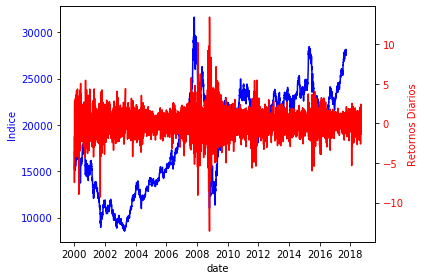

In [39]:
ret=np.log(data.close_price).diff(periods=1)*100  # calculo de los retornos.
fig, ax1 = plt.subplots()
ax1.set_xlabel('date')
ax1.set_ylabel('Indice', color='blue')
ax1.plot(data.index[1:4350], data.close_price[1:4350], color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()  
ax2.set_ylabel('Retornos Diarios', color='red')  
ax2.plot(data.index[1:4591],ret.values[1:4591], color='red')
ax2.tick_params(axis='y', labelcolor='red')
fig.tight_layout() 
plt.show()

Cuando cae el mercado se evidencia una alta volatilidad y cuando el indice esta al alza a volatilidad disminuye.

<img src="./Imagenes/4.1 .png" >  

In [40]:
print(data.index[4412] )

retornos_2017 = ret[1:4413]
retornos_2017

2017-12-29 00:00:00+00:00


2000-01-04 00:00:00+00:00   -1.723555
2000-01-05 00:00:00+00:00   -7.452519
2000-01-06 00:00:00+00:00   -4.474883
2000-01-07 00:00:00+00:00    1.651932
2000-01-10 00:00:00+00:00    2.831975
                               ...   
2017-12-21 00:00:00+00:00    0.506069
2017-12-22 00:00:00+00:00    0.499694
2017-12-27 00:00:00+00:00    0.260772
2017-12-28 00:00:00+00:00    0.857406
2017-12-29 00:00:00+00:00    0.263923
Name: close_price, Length: 4412, dtype: float64

In [41]:
basic_garch = arch_model(retornos_2017,p = 1, q = 1, vol = 'GARCH', dist = 'normal', mean = 'Zero')
basic_garch_fit = basic_garch.fit()
print(basic_garch_fit.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 7211.432788831532
Iteration:      2,   Func. Count:     13,   Neg. LLF: 7210.9311068177185
Iteration:      3,   Func. Count:     19,   Neg. LLF: 7206.171582350629
Iteration:      4,   Func. Count:     25,   Neg. LLF: 7195.162903010063
Iteration:      5,   Func. Count:     31,   Neg. LLF: 7193.669853080518
Iteration:      6,   Func. Count:     37,   Neg. LLF: 7192.266086423005
Iteration:      7,   Func. Count:     43,   Neg. LLF: 7192.120406621477
Iteration:      8,   Func. Count:     49,   Neg. LLF: 7191.742077633147
Iteration:      9,   Func. Count:     54,   Neg. LLF: 7191.692045840382
Iteration:     10,   Func. Count:     59,   Neg. LLF: 7191.684660437633
Iteration:     11,   Func. Count:     64,   Neg. LLF: 7191.683898076903
Iteration:     12,   Func. Count:     69,   Neg. LLF: 7191.683796750284
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7191.683795850062
            Iterations: 12

<img src="./Imagenes/garch.png" > 

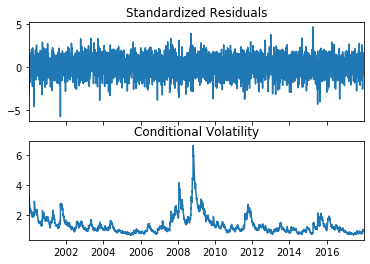

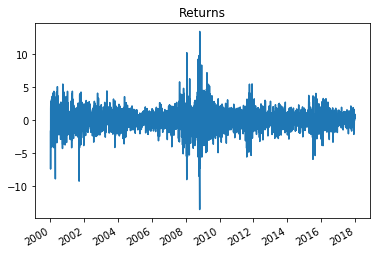

In [42]:
residuals = basic_garch_fit.resid # retornos ó el residuo de modelo 
std = basic_garch_fit.conditional_volatility # volatilidad condicional del modelo.

basic_garch_fit.plot()
plt.show()

retornos_2017.plot() # residual del modelo 
plt.title('Returns')
plt.show()

In [43]:
normal_teorico = pd.DataFrame(list(np.random.normal(0,1,len(std))), index = retornos_2017.index, columns = ['x'])


# Calculate the standardized residuals(ratio)
gm_std_resid = retornos_2017 /std # residuales estandarizados
gm_std_resid

2000-01-04 00:00:00+00:00   -0.643258
2000-01-05 00:00:00+00:00   -2.840952
2000-01-06 00:00:00+00:00   -1.428081
2000-01-07 00:00:00+00:00    0.512677
2000-01-10 00:00:00+00:00    0.902365
                               ...   
2017-12-21 00:00:00+00:00    0.531090
2017-12-22 00:00:00+00:00    0.534108
2017-12-27 00:00:00+00:00    0.283777
2017-12-28 00:00:00+00:00    0.955868
2017-12-29 00:00:00+00:00    0.293558
Length: 4412, dtype: float64

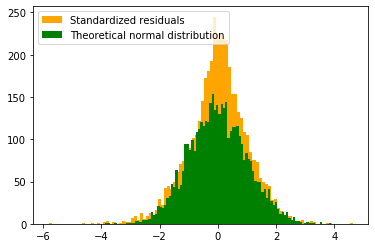

In [44]:
# Plot the histogram of the standardized residuals
plt.hist(gm_std_resid, bins = 100, facecolor = 'orange', label = 'Standardized residuals')
plt.hist(normal_teorico.x, bins = 100, facecolor = 'green', label = 'Theoretical normal distribution')
plt.legend(loc = 'upper left')
plt.show()

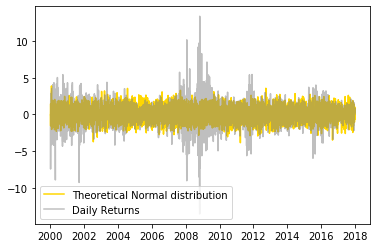

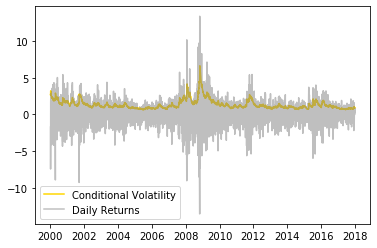

In [45]:
plt.plot(normal_teorico, color = 'gold', label = 'Theoretical Normal distribution')
plt.plot(retornos_2017, color = 'grey', label = 'Daily Returns', alpha = 0.5)
plt.legend(loc = 'lower left')
plt.show()

plt.plot(std, color = 'gold', label = 'Conditional Volatility')
plt.plot(retornos_2017, color = 'grey', label = 'Daily Returns', alpha = 0.5)
plt.legend(loc = 'lower left')
plt.show()

<img src="./Imagenes/4.2 .png" >  

In [46]:
def ewma(lamnda,retornos):
    retornos = retornos/100 # para que no esten en porcentajes 
    return_squared = retornos**2  # retornos al cuadrado en t+1
    var_initial = np.std(return_squared) ** 2  # varianza de los retornos ^(2)
    
    
    variance_model = [var_initial]*(retornos.shape[0] + 1 )
    vol_ewma = [np.sqrt(var_initial)]
    
    for i in range(1,len(variance_model),1): 
        variance_model[i] = (1-lamnda)*return_squared[i-1] + lamnda*variance_model[i-1]
        vol_ewma.append(np.sqrt(variance_model[i]))
    
    vol_ewma= np.array(vol_ewma)*100
    variance_model= np.array(variance_model)*100
    ewmas = pd.DataFrame({'volatility':vol_ewma,'variance':variance_model})
    ewmas = ewmas.iloc[1:]
    ewmas.index = return_squared.index
    return(ewmas)

In [47]:
parametro = 0.95

ewmas = ewma(parametro,retornos_2017) # voalitilidad, varianza
ewmas

,volatility,variance
2000-01-04 00:00:00+00:00,0.391503,0.001533
2000-01-05 00:00:00+00:00,1.709565,0.029226
2000-01-06 00:00:00+00:00,1.943633,0.037777
2000-01-07 00:00:00+00:00,1.930096,0.037253
2000-01-10 00:00:00+00:00,1.984946,0.039400
...,...,...
2017-12-21 00:00:00+00:00,0.855024,0.007311
2017-12-22 00:00:00+00:00,0.840831,0.007070
2017-12-27 00:00:00+00:00,0.821612,0.006750
2017-12-28 00:00:00+00:00,0.823439,0.006781


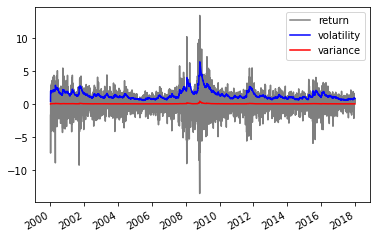

In [48]:
retornos_2017.plot(label='return', color = 'black',alpha = 0.5)
ewmas.volatility.plot(label='volatility', color = 'blue')
ewmas.variance.plot(label='variance', color = 'red')
plt.legend()
plt.show()

<img src="./Imagenes/4.3 .png" >  

* Si la ventana de la rolling window es muy grande entonces la serie es muy ancha y se enfoca en la varianza pero no en cambios asimetricos.
* Si la ventana de la rolling window es muy pequeño entonces la serie es muy corta y se enfoca en cambios asimetricos pero la varianza no se analiza.

In [49]:
retornos_2018 = ret[1:4837]
retornos_2018

2000-01-04 00:00:00+00:00   -1.723555
2000-01-05 00:00:00+00:00   -7.452519
2000-01-06 00:00:00+00:00   -4.474883
2000-01-07 00:00:00+00:00    1.651932
2000-01-10 00:00:00+00:00    2.831975
                               ...   
2019-09-24 00:00:00+01:00    0.294699
2019-09-25 00:00:00+01:00   -1.363504
2019-09-26 00:00:00+01:00    0.421382
2019-09-27 00:00:00+01:00   -0.432606
2019-09-30 00:00:00+01:00    0.446394
Name: close_price, Length: 4836, dtype: float64

In [50]:
def rolling_window_garch(open_window,window_size,data, p, q): 
    end_loc = data.shape[0] - open_window # ultima fecha de data que conocere con la rolling
    start_loc = end_loc - window_size  # el numero de obs que usare para estimar cada dia
    basic_garch = arch_model(data,p = p, q = q, vol = 'GARCH', dist = 'normal', mean = 'Zero')
    
    
    forecasts = {} # guardo el pronostico de rolling
    for i in range(open_window): 
        # Specify fixed rolling window size for model fitting
        gm_result = basic_garch.fit(first_obs = i + start_loc, 
                             last_obs = i + end_loc,update_freq = window_size)# re ajusta el parametro cada semana
        # Conduct 1-period variance forecast and save the result
        temp_result = gm_result.forecast(horizon = 1).variance
        print(i)
        fcast = temp_result.iloc[i + end_loc]
        forecasts[fcast.name] = fcast

    # Save all forecast to a dataframe    
    forecast_var = pd.DataFrame(forecasts).T
    forecast_sigma = pd.DataFrame(np.sqrt(forecast_var))
    return(forecast_var,forecast_sigma)

### Parametros:

In [51]:
window_size = 60   # 60 meses ó 5 años
open_window = retornos_2018.shape[0] -retornos_2017.shape[0]   # abrir la ventana de tiempo entre 

forecast_var_63,forecast_sigma_63 = rolling_window_garch(open_window,window_size,retornos_2018, 1, 1)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 68.34569055790267
            Iterations: 7
            Function evaluations: 39
            Gradient evaluations: 7
0
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 69.88217198632485
            Iterations: 7
            Function evaluations: 40
            Gradient evaluations: 7
1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 70.28020706553646
            Iterations: 8
            Function evaluations: 47
            Gradient evaluations: 8
2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 70.60519027940262
            Iterations: 6
            Function evaluations: 35
            Gradient evaluations: 6
3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 70.54994656543066
            Iterations: 7
            Function eval

49
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 96.84023342228207
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 8
50
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 97.3892039754437
            Iterations: 8
            Function evaluations: 47
            Gradient evaluations: 8
51
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 97.33595952884257
            Iterations: 8
            Function evaluations: 47
            Gradient evaluations: 8
52
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 97.6076754187183
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 8
53
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 97.86283909663871
            Iterations: 9
            Function

101
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 91.0311691316195
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8
102
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 90.56245751574355
            Iterations: 12
            Function evaluations: 67
            Gradient evaluations: 12
103
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 88.9122945432333
            Iterations: 10
            Function evaluations: 54
            Gradient evaluations: 10
104
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 88.58173029645936
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8
105
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 88.11041678827145
            Iterations: 7
           

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 86.76905577097114
            Iterations: 19
            Function evaluations: 105
            Gradient evaluations: 19
152
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 87.92199081859495
            Iterations: 12
            Function evaluations: 63
            Gradient evaluations: 12
153
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 87.95534088056196
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8
154
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 86.85672328906074
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8
155
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 87.69266457687688
            Iterations: 8
            

193
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 95.59547018834849
            Iterations: 7
            Function evaluations: 41
            Gradient evaluations: 7
194
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 95.66949037317053
            Iterations: 7
            Function evaluations: 40
            Gradient evaluations: 7
195
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 96.09811240941328
            Iterations: 7
            Function evaluations: 40
            Gradient evaluations: 7
196
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 95.3210234994976
            Iterations: 6
            Function evaluations: 35
            Gradient evaluations: 6
197
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 96.4152319485734
            Iterations: 8
            Fun

242
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 104.99835750522112
            Iterations: 7
            Function evaluations: 38
            Gradient evaluations: 7
243
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 104.36911512937094
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8
244
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 103.96649961442563
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 6
245
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 106.57041032202608
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 9
246
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 105.66923223228268
            Iterations: 7
        

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 87.29603628731381
            Iterations: 6
            Function evaluations: 36
            Gradient evaluations: 6
295
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 86.0838576803094
            Iterations: 6
            Function evaluations: 35
            Gradient evaluations: 6
296
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 86.03293414427402
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 6
297
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 86.02024042972555
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 6
298
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 86.01468784278732
            Iterations: 6
            Functi

335
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 81.82482125394176
            Iterations: 5
            Function evaluations: 32
            Gradient evaluations: 5
336
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 83.36123191153405
            Iterations: 6
            Function evaluations: 36
            Gradient evaluations: 6
337
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 83.14274818642909
            Iterations: 6
            Function evaluations: 36
            Gradient evaluations: 6
338
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 83.09624281734236
            Iterations: 6
            Function evaluations: 37
            Gradient evaluations: 6
339
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 82.99280539048213
            Iterations: 6
            F

379
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 84.63802889028995
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 8
380
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 85.22759322806063
            Iterations: 10
            Function evaluations: 56
            Gradient evaluations: 10
381
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 84.99963126408952
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8
382
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 88.21060437123587
            Iterations: 10
            Function evaluations: 55
            Gradient evaluations: 10
383
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 90.83213895492909
            Iterations: 8
         

418
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 88.09272454462032
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
419
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 88.37805139199216
            Iterations: 7
            Function evaluations: 43
            Gradient evaluations: 7
420
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 88.5888423560165
            Iterations: 8
            Function evaluations: 47
            Gradient evaluations: 8
421
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 88.87923640843744
            Iterations: 19
            Function evaluations: 103
            Gradient evaluations: 18
422
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 89.1381175109974
            Iterations: 18
         

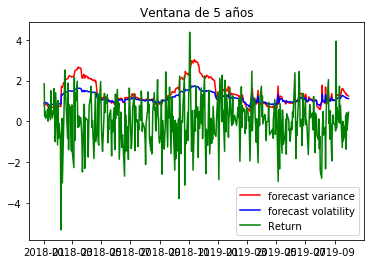

In [52]:
plt.plot(forecast_var_63, color = 'red', label = 'forecast variance')
plt.plot(forecast_sigma_63, color = 'blue', label = 'forecast volatility')
plt.plot(retornos_2018.tail(open_window), color = 'green', label = 'Return')
plt.title('Ventana de 5 años')
plt.legend()
plt.show()

In [53]:
window_size = 12   # 12 meses o 1 año

forecast_var_10,forecast_sigma_10 = rolling_window_garch(open_window,window_size,retornos_2018, 1, 1)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12.598555562651697
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 6
0
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 15.384657752964761
            Iterations: 7
            Function evaluations: 38
            Gradient evaluations: 7
1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 13.372624927280274
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 6
2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 13.581780413157297
            Iterations: 11
            Function evaluations: 57
            Gradient evaluations: 11
3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12.76273147162312
            Iterations: 6
            Functio

40
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 20.315165445239078
            Iterations: 7
            Function evaluations: 38
            Gradient evaluations: 7
41
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 20.907767404209082
            Iterations: 8
            Function evaluations: 45
            Gradient evaluations: 8
42
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 21.89902232590775
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10
43
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 21.44532605345266
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9
44
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 20.9782842915471
            Iterations: 5
            Fun

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 17.1775165893667
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9
79
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 18.729008322806834
            Iterations: 6
            Function evaluations: 32
            Gradient evaluations: 6
80
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 18.842772204386495
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8
81
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 17.92529863090819
            Iterations: 7
            Function evaluations: 37
            Gradient evaluations: 7
82
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 18.62848045443957
            Iterations: 7
            Function

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 19.66656989038157
            Iterations: 7
            Function evaluations: 39
            Gradient evaluations: 7
119
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 19.72814365130283
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8
120
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 20.52229841606007
            Iterations: 3
            Function evaluations: 17
            Gradient evaluations: 3
121
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 20.560233988890825
            Iterations: 3
            Function evaluations: 17
            Gradient evaluations: 3
122
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 20.658543045476975
            Iterations: 7
            Fun

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 16.274331880648663
            Iterations: 7
            Function evaluations: 37
            Gradient evaluations: 7
159
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 16.119052329482894
            Iterations: 5
            Function evaluations: 28
            Gradient evaluations: 5
160
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 17.982754530968847
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9
161
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 17.68778380105101
            Iterations: 10
            Function evaluations: 54
            Gradient evaluations: 10
162
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 16.700401510028527
            Iterations: 9
           

Iteration:     12,   Func. Count:     64,   Neg. LLF: 23.025198521836565
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 23.025169391817837
            Iterations: 13
            Function evaluations: 69
            Gradient evaluations: 13
198
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 23.991878949211838
            Iterations: 8
            Function evaluations: 41
            Gradient evaluations: 8
199
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 24.12497446404282
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9
200
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 23.973817924485918
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10
201
Optimization terminated successfully.    (Exit mode 0)
            Curre

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 20.76528098302137
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9
236
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 20.531101335959388
            Iterations: 7
            Function evaluations: 37
            Gradient evaluations: 7
237
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 20.646479677932444
            Iterations: 7
            Function evaluations: 37
            Gradient evaluations: 7
238
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 19.207535308605745
            Iterations: 7
            Function evaluations: 38
            Gradient evaluations: 7
239
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 19.206409314258707
            Iterations: 7
            F

276
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 15.936667071816839
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8
277
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 16.41215358351417
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8
278
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 15.523493093224037
            Iterations: 7
            Function evaluations: 39
            Gradient evaluations: 7
279
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 15.827134910996852
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8
280
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 15.993812434212085
            Iterations: 10
        

            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9
317
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 10.39627193142288
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8
318
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.921197797234793
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 6
319
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 9.074151466338904
            Iterations: 7
            Function evaluations: 40
            Gradient evaluations: 7
320
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 10.661525951027643
            Iterations: 7
            Function evaluations: 40
            Gradient evaluations: 7
321
Optimization terminated successfully.    (Exit m

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 19.31579292270896
            Iterations: 4
            Function evaluations: 22
            Gradient evaluations: 4
359
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 18.96743035423797
            Iterations: 6
            Function evaluations: 32
            Gradient evaluations: 6
360
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 18.288126759309236
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10
361
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 17.940212712778216
            Iterations: 7
            Function evaluations: 37
            Gradient evaluations: 7
362
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 17.81394125330177
            Iterations: 11
            

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 18.73373975367065
            Iterations: 7
            Function evaluations: 39
            Gradient evaluations: 7
400
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 18.438585692262134
            Iterations: 5
            Function evaluations: 27
            Gradient evaluations: 5
401
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 16.309188542532155
            Iterations: 4
            Function evaluations: 22
            Gradient evaluations: 4
402
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 16.00187388862869
            Iterations: 7
            Function evaluations: 37
            Gradient evaluations: 7
403
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 15.13982370292536
            Iterations: 5
            Fun

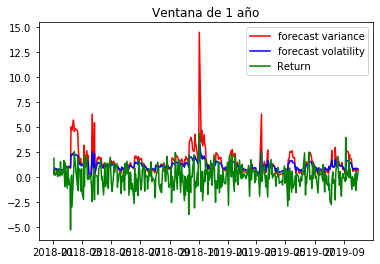

In [54]:
plt.plot(forecast_var_10, color = 'red', label = 'forecast variance')
plt.plot(forecast_sigma_10, color = 'blue', label = 'forecast volatility')
plt.plot(retornos_2018.tail(open_window), color = 'green', label = 'Return')
plt.title('Ventana de 1 año')
plt.legend()
plt.show()

### Modelo EWMA:

In [55]:
retornos_2018.head()

2000-01-04 00:00:00+00:00   -1.723555
2000-01-05 00:00:00+00:00   -7.452519
2000-01-06 00:00:00+00:00   -4.474883
2000-01-07 00:00:00+00:00    1.651932
2000-01-10 00:00:00+00:00    2.831975
Name: close_price, dtype: float64

In [56]:
lamnda = 0.95
ewmas_2018 = ewma(lamnda,retornos_2018)
ewmas_2018.tail()

,volatility,variance
2019-09-24 00:00:00+01:00,1.060822,0.011253
2019-09-25 00:00:00+01:00,1.077977,0.011620
2019-09-26 00:00:00+01:00,1.054898,0.011128
2019-09-27 00:00:00+01:00,1.032728,0.010665
2019-09-30 00:00:00+01:00,1.011516,0.010232


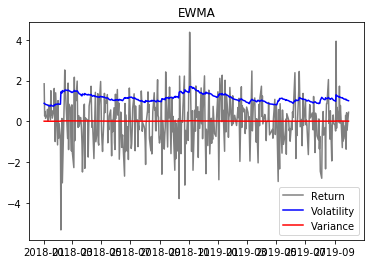

In [57]:
plt.plot(retornos_2018.iloc[retornos_2017.shape[0]:        ], label='Return', color = 'black',alpha = 0.5)
plt.plot(ewmas_2018.volatility.iloc[retornos_2017.shape[0]:], label='Volatility', color = 'blue')
plt.plot(ewmas_2018.variance.iloc[retornos_2017.shape[0]:  ], label='Variance', color = 'red')
plt.title('EWMA')
plt.legend()
plt.show()

### Comparación del modelo garch con diferente ventana de tiempo:

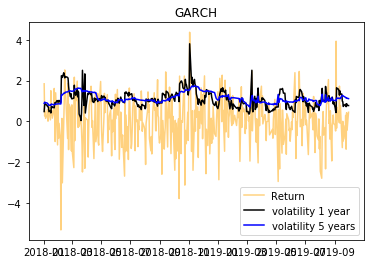

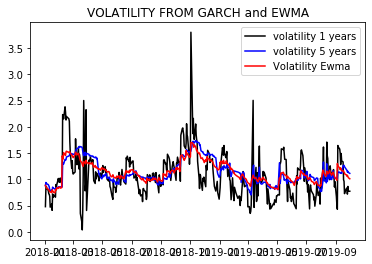

In [58]:
plt.plot(retornos_2018.tail(open_window), color = 'orange', label = 'Return',alpha = 0.5)
plt.plot(forecast_sigma_10, color = 'black', label = 'volatility 1 year')
plt.plot(forecast_sigma_63, color = 'blue', label = 'volatility 5 years')
plt.title('GARCH')
plt.legend()
plt.show()

plt.plot(forecast_sigma_10, color = 'black', label = 'volatility 1 years')
plt.plot(forecast_sigma_63, color = 'blue', label = 'volatility 5 years')
plt.plot(ewmas_2018.volatility.iloc[retornos_2017.shape[0]:], label='Volatility Ewma', color = 'red')
plt.title('VOLATILITY FROM GARCH and EWMA')
plt.legend()
plt.show()

### En algunos fondos de inversion, el mejor pronostico es la volatilidad mas alta entre las diferentes metodologias:

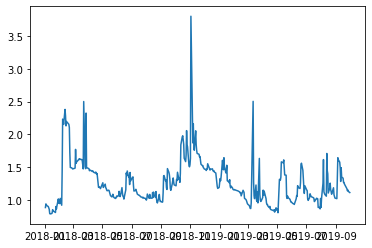

In [59]:
output = pd.DataFrame({'A':forecast_sigma_10['h.1'].tolist(),
                       'B':forecast_sigma_63['h.1'].tolist(),
                       'C':ewmas_2018.volatility.iloc[retornos_2017.shape[0]:].tolist()})

output = output[['A','B','C']].apply(max, axis=1)
plt.plot(forecast_sigma_63.index,output)

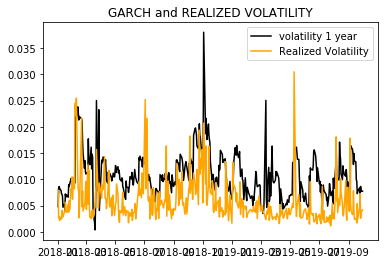

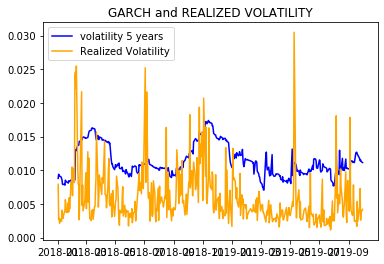

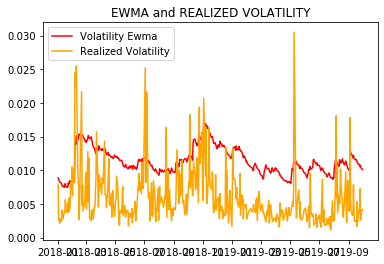

In [60]:
plt.plot(forecast_sigma_10/100, color = 'black', label = 'volatility 1 year')
plt.plot(data["rv5"].iloc[retornos_2017.shape[0]+1:retornos_2018.shape[0]+1]*100, label='Realized Volatility', color = 'orange')
plt.title('GARCH and REALIZED VOLATILITY')
plt.legend()
plt.show()



plt.plot(forecast_sigma_63/100, color = 'blue', label = 'volatility 5 years')
plt.plot(data["rv5"].iloc[retornos_2017.shape[0]+1:retornos_2018.shape[0]+1]*100, label='Realized Volatility',color = 'orange')
plt.title('GARCH and REALIZED VOLATILITY')
plt.legend()
plt.show()


plt.plot(ewmas_2018.volatility.iloc[retornos_2017.shape[0]:]/100, label='Volatility Ewma', color = 'red')
plt.plot(data["rv5"].iloc[retornos_2017.shape[0]+1:retornos_2018.shape[0]+1]*100, label='Realized Volatility',color = 'orange')
plt.title('EWMA and REALIZED VOLATILITY')
plt.legend()
plt.show()

In [61]:
print('El RMSE para el garch(1,1) con rolling window de 1 año: ',RMSE(data["rv5"].iloc[retornos_2017.shape[0]+1:retornos_2018.shape[0]+1]*100, forecast_sigma_10['h.1']/100))
print('El RMSE para el garch(1,1) con rolling window de 5 años: ',RMSE(data["rv5"].iloc[retornos_2017.shape[0]+1:retornos_2018.shape[0]+1]*100, forecast_sigma_63['h.1']/100))
print('El RMSE para el modelo EWMMA: ',RMSE(data["rv5"].iloc[retornos_2017.shape[0]+1:retornos_2018.shape[0]+1]*100, ewmas_2018.volatility.iloc[retornos_2017.shape[0]:]/100))

El RMSE para el garch(1,1) con rolling window de 1 año:  0.00658
El RMSE para el garch(1,1) con rolling window de 5 años:  0.00679
El RMSE para el modelo EWMMA:  0.00658


In [62]:
print('El MAE para el garch(1,1) con rolling window de 1 año: ',MAE(data["rv5"].iloc[retornos_2017.shape[0]+1:retornos_2018.shape[0]+1]*100, forecast_sigma_10['h.1']/100))
print('El MAE para el garch(1,1) con rolling window de 5 años: ',MAE(data["rv5"].iloc[retornos_2017.shape[0]+1:retornos_2018.shape[0]+1]*100, forecast_sigma_63['h.1']/100))
print('El MAE para el modelo EWMMA: ',MAE(data["rv5"].iloc[retornos_2017.shape[0]+1:retornos_2018.shape[0]+1]*100, ewmas_2018.volatility.iloc[retornos_2017.shape[0]:]/100))

El MAE para el garch(1,1) con rolling window de 1 año:  0.00552
El MAE para el garch(1,1) con rolling window de 5 años:  0.00615
El MAE para el modelo EWMMA:  0.00605
